# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [2]:
import pandas as pd
import re

## Mutational catalogs and activities - WGS data

In [3]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [4]:
## Activities

PCAWG_wgs_act = pd.read_csv ("project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,...,Stomach-AdenoCa::pfg316T,Stomach-AdenoCa::pfg317T,Stomach-AdenoCa::pfg344T,Stomach-AdenoCa::pfg373T,Stomach-AdenoCa::pfg375T,Stomach-AdenoCa::pfg378T,Stomach-AdenoCa::pfg398T,Stomach-AdenoCa::pfg413T,Stomach-AdenoCa::pfg416T,Stomach-AdenoCa::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,...,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,...,48,70,126,88,35,54,16,112,31,91


In [6]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [6]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [9]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [79]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [80]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'
                      )
print(device)  # cpu or cuda

cpu


In [122]:
# list all the types of mutations

mutTypes = np.array(PCAWG_wgs_mutT.index.str.split("::").str[0])
unique, counts = np.unique(mutTypes, return_counts=True)
sampCounts = dict(zip(unique, counts))
dict(zip(unique, counts))

{'Biliary-AdenoCA': 35,
 'Bladder-TCC': 23,
 'Bone-Benign': 16,
 'Bone-Epith': 11,
 'Bone-Osteosarc': 38,
 'Breast-AdenoCA': 198,
 'Breast-DCIS': 3,
 'Breast-LobularCA': 13,
 'CNS-GBM': 41,
 'CNS-Medullo': 146,
 'CNS-Oligo': 18,
 'CNS-PiloAstro': 89,
 'Cervix-AdenoCA': 2,
 'Cervix-SCC': 18,
 'ColoRect-AdenoCA': 60,
 'Eso-AdenoCA': 98,
 'Head-SCC': 57,
 'Kidney-ChRCC': 45,
 'Kidney-RCC': 144,
 'Liver-HCC': 326,
 'Lung-AdenoCA': 38,
 'Lung-SCC': 48,
 'Lymph-BNHL': 107,
 'Lymph-CLL': 95,
 'Myeloid-AML': 11,
 'Myeloid-MDS': 4,
 'Myeloid-MPN': 56,
 'Ovary-AdenoCA': 113,
 'Panc-AdenoCA': 241,
 'Panc-Endocrine': 85,
 'Prost-AdenoCA': 286,
 'Skin-Melanoma': 107,
 'SoftTissue-Leiomyo': 15,
 'SoftTissue-Liposarc': 19,
 'Stomach-AdenoCA': 75,
 'Thy-AdenoCA': 48,
 'Uterus-AdenoCA': 51,
 'mut_tri': 1}

In [123]:
#list all the tissue types

tissueTypes = np.array(PCAWG_wgs_mutT.index.str.split("-").str[0])
unique, counts = np.unique(tissueTypes, return_counts=True)
tissueCounts = dict(zip(unique, counts))
dict(zip(unique, counts))

{'Biliary': 35,
 'Bladder': 23,
 'Bone': 65,
 'Breast': 214,
 'CNS': 294,
 'Cervix': 20,
 'ColoRect': 60,
 'Eso': 98,
 'Head': 57,
 'Kidney': 189,
 'Liver': 326,
 'Lung': 86,
 'Lymph': 202,
 'Myeloid': 71,
 'Ovary': 113,
 'Panc': 326,
 'Prost': 286,
 'Skin': 107,
 'SoftTissue': 34,
 'Stomach': 75,
 'Thy': 48,
 'Uterus': 51,
 'mut_tri': 1}

In [100]:
PCAWG_wgs_mut.head()

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550,mut_tri
0,C>A,ACA,269,114,105,217,52,192,54,196,...,233,94,114,257,139,404,97,250,170,C>A_ACA
1,C>A,ACC,148,56,71,123,36,139,54,102,...,167,59,64,268,75,255,78,188,137,C>A_ACC
2,C>A,ACG,25,13,13,29,8,31,12,15,...,29,14,19,51,13,52,14,49,32,C>A_ACG
3,C>A,ACT,154,70,73,126,31,119,41,122,...,213,66,68,271,68,281,80,202,116,C>A_ACT
4,C>A,CCA,215,63,71,129,30,190,54,133,...,188,67,89,307,69,339,204,194,127,C>A_CCA


In [82]:

n_mut_types, n_samples = PCAWG_wgs_mut.shape
print(PCAWG_wgs_mut.shape)
mutations = PCAWG_wgs_mut

mutations['mut_tri'] = mutations.apply(lambda a: '{}_{}'.format(a['Mutation type'], a['Trinucleotide']), axis=1)
mutations = mutations.set_index('mut_tri').drop(['Mutation type', 'Trinucleotide'], axis=1)
mutations = mutations.T
print(mutations[:3])


tumor_types = [a.split(':')[0] for a in mutations.index]
print('{} unique tumor types'.format(len(set(tumor_types))))


(96, 2783)
mut_tri                    C>A_ACA  C>A_ACC  C>A_ACG  C>A_ACT  C>A_CCA  \
Biliary-AdenoCA::SP117655      269      148       25      154      215   
Biliary-AdenoCA::SP117556      114       56       13       70       63   
Biliary-AdenoCA::SP117627      105       71       13       73       71   

mut_tri                    C>A_CCC  C>A_CCG  C>A_CCT  C>A_GCA  C>A_GCC  ...  \
Biliary-AdenoCA::SP117655      148       27      180      165       76  ...   
Biliary-AdenoCA::SP117556       49        7       69       81       37  ...   
Biliary-AdenoCA::SP117627       55        8       61       61       50  ...   

mut_tri                    T>G_CTG  T>G_CTT  T>G_GTA  T>G_GTC  T>G_GTG  \
Biliary-AdenoCA::SP117655       49      268       19       17       43   
Biliary-AdenoCA::SP117556       23       53        8        5       20   
Biliary-AdenoCA::SP117627        8       44        7        6       14   

mut_tri                    T>G_GTT  T>G_TTA  T>G_TTC  T>G_TTG  T>G_TTT  
Bilia

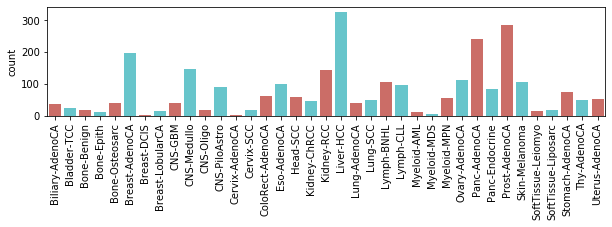

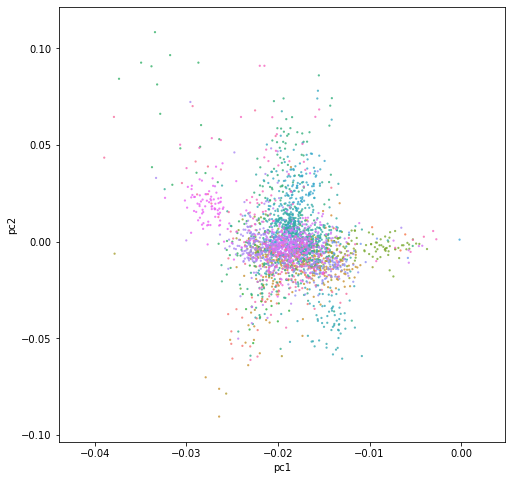

In [84]:
# visualize key characteristics

plt.figure(figsize=(10, 2))
sns.countplot(tumor_types, palette=sns.hls_palette(2))
plt.xticks(rotation=90)
plt.show()

# Principal component analysis to get an overview of how tumors cluster according to their somatic mutation patterns

log_mutations = np.log10(mutations + 1)

pca = PCA(n_components=2).fit(log_mutations.T)
pca_res = pd.DataFrame(pca.components_.T, columns=['pc1', 'pc2'])
pca_res['tumor_type'] = tumor_types

plt.figure(figsize=(8, 8))
sns.scatterplot('pc1', 'pc2', hue='tumor_type', data=pca_res, legend=False, s=5, linewidth=0, alpha=0.8)
plt.show()


In [ ]:
#Supervised learning model with multilayer predictor
#Works poorly, only ~20 % accuracy
# Can be expanded to multiple cancer types but the accuracy dips further down

In [143]:

labels_hcc = [1 if t == 'Biliary-AdenoCA' else 0 for t in tumor_types]
print('{} HCCs out of {} tumors ({:.1%})'.format(sum(labels_hcc), len(labels_hcc),
                                                 sum(labels_hcc) / len(labels_hcc)))

35 HCCs out of 2780 tumors (1.3%)


In [144]:
data_hcc = torch.utils.data.TensorDataset(torch.Tensor(np.array(log_mutations)),
                                                torch.Tensor(labels_hcc))
train_hcc, val_hcc = torch.utils.data.random_split(data_hcc, [int(0.7 * len(data_hcc)), 
                                                              len(data_hcc) - int(0.7 * len(data_hcc))])
print('{:.0f}/{} HCCs/total ({:.1%}) in training set, {:.0f}/{} HCCs/total ({:.1%}) in validation set'.format(\
    train_hcc[:][1].sum(), len(train_hcc), train_hcc[:][1].sum() / len(train_hcc),
    val_hcc[:][1].sum(), len(val_hcc), val_hcc[:][1].sum() / len(val_hcc)))

23/1945 HCCs/total (1.2%) in training set, 12/835 HCCs/total (1.4%) in validation set


In [145]:
class MultilayerPredictor(torch.nn.Module):
    def __init__(self, input_shape, output_shape=1, hidden_dim=1024, **kwargs):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features=input_shape, out_features=hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.fc2 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.fc3 = torch.nn.Linear(in_features=hidden_dim, out_features=output_shape)

    def forward(self, x):
        l1 = torch.relu(self.bn1(self.fc1(x)))
        l2 = torch.relu(self.bn2(self.fc2(l1)))
        return torch.sigmoid(self.fc3(l2)).reshape(-1)

In [146]:
model_3 = MultilayerPredictor(input_shape=n_mut_types).to(device)
optimizer_3 = torch.optim.SGD(model.parameters(), lr=1e-2)
objective_3 = torch.nn.BCELoss()
epochs = 30

In [89]:
print_stats_interval = 10
log_3 = []

for epoch in range(epochs):
    loss = n_correct = 0
    model_3.train()
    for batch, target in train_hcc_loader:
        batch = batch.view(-1, n_mut_types).to(device)
        optimizer_3.zero_grad()
        outputs = model_3(batch)
        train_loss = objective_3(outputs, target)
        loss += train_loss.item()
        n_correct += (target == (outputs.reshape(-1) > 0.5).float()).sum()
        train_loss.backward()
        optimizer3.step()
    
    loss = loss / len(train_hcc_loader)    
    acc = (n_correct.float() / len(train_hcc)).numpy()
    epoch += 1
    #Evaluation    
    model_3.eval();
    val_loss = val_n_correct = 0
    with torch.no_grad():
        for batch, target in val_hcc_loader:
            batch = batch.view(-1, n_mut_types).to(device)
            outputs = model3(batch)
            val_loss += objective3(outputs, target)
            val_n_correct += (target == (outputs.reshape(-1) > 0.5).float()).sum()
    val_loss = (val_loss / len(val_hcc_loader)).numpy()
    val_acc = (val_n_correct.float() / len(val_hcc)).numpy()
    
    if (epoch % print_stats_interval) == 0 or epoch == epochs:
        print(f'epoch={epoch:.0f}, loss={loss:.5f}, val_loss={np.round(val_loss,5):.5f}, acc={np.round(acc,5):.5f}, val_acc={np.round(val_acc,5):.5f}')
    log3.append((epoch, loss, val_loss, acc, val_acc))
log3 = pd.DataFrame(log3, columns=['epoch', 'loss', 'val_loss', 'acc', 'val_acc'])


epoch=10, loss=0.94113, val_loss=0.91866, acc=0.17275, val_acc=0.20359
epoch=20, loss=0.94016, val_loss=0.91869, acc=0.17686, val_acc=0.20240
epoch=30, loss=0.94037, val_loss=0.92834, acc=0.17738, val_acc=0.20000


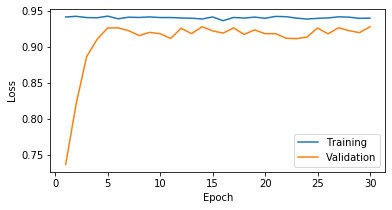

In [90]:
plt.figure(figsize=(6, 3))
plt.plot(log3['epoch'], log3['loss'], label='Training');
plt.plot(log3['epoch'], log3['val_loss'], label='Validation');
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend();

In [91]:
val_log_mutations = val_hcc[:][0].numpy().reshape(-1)
val_true_labels = val_hcc[:][1].numpy() + 0

res = model3(val_hcc[:][0])
predictions = (res.detach().numpy().reshape(-1) > 0.5) + 0
correct = (val_true_labels == predictions) + 0
n_correct = correct.sum()
print('{}/{} ({:.1%}) in the validation set'.format(n_correct, len(correct), n_correct / len(correct)))
print('Majority classifier accuracy: {:.1%}'.format((len(correct) - val_true_labels.sum()) / len(correct)))


151/835 (18.1%) in the validation set
Majority classifier accuracy: 90.3%


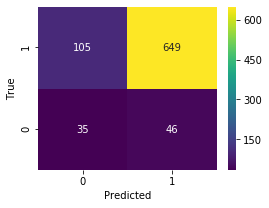

In [139]:
cm = sklearn.metrics.confusion_matrix(val_true_labels, predictions)
plt.figure(figsize=(4, 3))
sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='viridis');
plt.xlabel('Predicted'); plt.ylabel('True');
plt.ylim(0, 2); 


In [ ]:

# Activities

In [39]:
n_mut_types, n_samples = PCAWG_wgs_act.shape

In [ ]:
# Checks only one type of cancer and tries to predict cancer types
# Uses logistic regression model as shown in exercise 4 
# Examples of accuracy:

# Liver HCC acc 0.889
# Biliary-AdenoCA 0.98443
# Bladder-TCC 0.99280
# Breast-AdenoCA 0.92751
# CNS-Medullo 0.95219

# Most accuracies above 90%

In [191]:
labels_hcc = [1 if t == 'CNS-Medullo' else 0 for t in tumor_types]
print('{} HCCs out of {} tumors ({:.1%})'.format(sum(labels_hcc), len(labels_hcc),
                                                 sum(labels_hcc) / len(labels_hcc)))

146 HCCs out of 2780 tumors (5.3%)


In [192]:
data_hcc = torch.utils.data.TensorDataset(torch.Tensor(np.array(log_mutations)),
                                                torch.Tensor(labels_hcc))
train_hcc, val_hcc = torch.utils.data.random_split(data_hcc, [int(0.7 * len(data_hcc)), 
                                                              len(data_hcc) - int(0.7 * len(data_hcc))])
print('{:.0f}/{} HCCs/total ({:.1%}) in training set, {:.0f}/{} HCCs/total ({:.1%}) in validation set'.format(\
    train_hcc[:][1].sum(), len(train_hcc), train_hcc[:][1].sum() / len(train_hcc),
    val_hcc[:][1].sum(), len(val_hcc), val_hcc[:][1].sum() / len(val_hcc)))

104/1945 HCCs/total (5.3%) in training set, 42/835 HCCs/total (5.0%) in validation set


In [193]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_shape, output_shape=1, **kwargs):
        super().__init__()
        self.fc = torch.nn.Linear(in_features=input_shape, out_features=output_shape)

    def forward(self, x):
        return torch.sigmoid(self.fc(x)).reshape(-1)

In [194]:
train_hcc_loader = torch.utils.data.DataLoader(train_hcc, batch_size=128, 
                                               shuffle=True, num_workers=10, pin_memory=True)
val_hcc_loader = torch.utils.data.DataLoader(val_hcc, batch_size=128, 
                                             shuffle=False, num_workers=10, pin_memory=True)
model = LogisticRegression(input_shape=n_mut_types).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
objective = torch.nn.BCELoss()
epochs = 10

In [195]:
print_stats_interval = 10
log = []


for epoch in range(epochs):
    loss = n_correct = 0
   
    model.train()
    for batch, target in train_hcc_loader:
        batch = batch.view(-1, n_mut_types).to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        train_loss = objective(outputs, target)
        loss += train_loss.item()
        n_correct += (target == (outputs.reshape(-1) > 0.5).float()).sum()
        train_loss.backward()
        optimizer.step()
    
    loss = loss / len(train_hcc_loader)    
    acc = n_correct.float() / len(train_hcc)
    #acc = n_correct
    epoch += 1
        
    model.eval();
    val_loss = val_n_correct = 0
    with torch.no_grad():  
        for batch, target in val_hcc_loader:
            batch = batch.view(-1, n_mut_types).to(device)
            outputs = model(batch)
            val_loss += objective(outputs, target)
            val_n_correct += (target == (outputs.reshape(-1) > 0.5).float()).sum()
    val_loss = val_loss / len(val_hcc_loader)
    val_acc = val_n_correct.float() / len(val_hcc)
    
    if (epoch % print_stats_interval) == 0 or epoch == epochs:
        print('epoch={:.0f}, loss={:.5f}, val_loss={:.5f}, acc={:.5f}, val_acc={:.5f}'.format(epoch, loss, val_loss, acc, val_acc))
    log.append((epoch, loss, val_loss, acc, val_acc))
log = pd.DataFrame(log, columns=['epoch', 'loss', 'val_loss', 'acc', 'val_acc'])

epoch=10, loss=0.16559, val_loss=0.16265, acc=0.94653, val_acc=0.94970


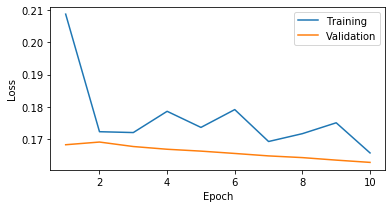

In [196]:
plt.figure(figsize=(6, 3))
plt.plot(log['epoch'], log['loss'], label='Training');
plt.plot(log['epoch'], log['val_loss'], label='Validation');
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend();

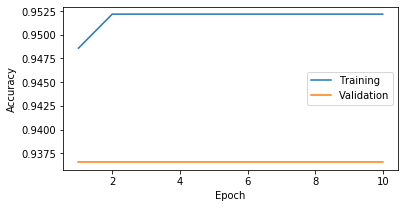

In [171]:
plt.figure(figsize=(6, 3))
plt.plot(log['epoch'], log['acc'], label='Training');
plt.plot(log['epoch'], log['val_acc'], label='Validation');
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

In [190]:
val_log_mutations = val_hcc[:][0].numpy().reshape(-1)
val_true_labels = val_hcc[:][1].numpy() + 0

res = model(val_hcc[:][0])
predictions = (res.detach().numpy().reshape(-1) > 0.5) + 0
correct = (val_true_labels == predictions) + 0
n_correct = correct.sum()
print('{}/{} ({:.1%}) in the validation set'.format(n_correct, len(correct), n_correct / len(correct)))
print('Majority classifier accuracy: {:.1%}'.format((len(correct) - val_true_labels.sum()) / len(correct)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


AttributeError: 'int' object has no attribute 'sum'

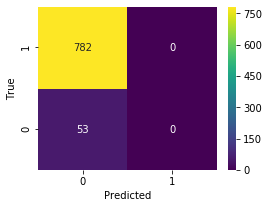

In [173]:
cm = sklearn.metrics.confusion_matrix(val_true_labels, predictions)
plt.figure(figsize=(4, 3))
sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='viridis');
plt.xlabel('Predicted'); plt.ylabel('True');
plt.ylim(0, 2); 



In [ ]:
# non-supervised learning with autoencoder wiht mutation catalogs
# loss only ~0.01 if epochs are high enough, but will result in long run time
# very high accuracy

In [174]:
mutations = PCAWG_wgs_mut
n_mut_types, n_samples = mutations.shape
print(mutations.shape)


(96, 2783)


In [180]:

torch.set_default_tensor_type('torch.FloatTensor')

train = torch.utils.data.TensorDataset(torch.Tensor(np.array(log_mutations)),
                                       torch.Tensor(np.zeros(mutations.shape[0])))

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=10, pin_memory=True)


In [186]:
# autoencoder model

class AE(torch.nn.Module):
    def __init__(self, hidden_dim=1024, latent_dim=2, **kwargs):
        super().__init__()
        self.enc_fc1 = torch.nn.Linear(in_features=kwargs["input_shape"], out_features=hidden_dim)
        self.enc_bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.enc_fc2 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.enc_fc2 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.enc_bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.enc_fc3 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.enc_bn3 = torch.nn.BatchNorm1d(hidden_dim)
        self.enc_output = torch.nn.Linear(in_features=hidden_dim, out_features=latent_dim)
        self.dec_fc1 = torch.nn.Linear(in_features=latent_dim, out_features=hidden_dim)
        self.dec_bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.dec_fc2 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.dec_bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.dec_fc3 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.dec_bn3 = torch.nn.BatchNorm1d(hidden_dim)
        self.dec_output = torch.nn.Linear(in_features=hidden_dim, out_features=kwargs["input_shape"])

    def encode(self, x):
        e1 = torch.relu(self.enc_bn1(self.enc_fc1(x)))
        e2 = torch.relu(self.enc_bn2(self.enc_fc2(e1)))
        e3 = torch.relu(self.enc_bn3(self.enc_fc3(e2)))
        return self.enc_output(e3)

    def decode(self, latent):
        d1 = torch.relu(self.dec_bn1(self.dec_fc1(latent)))
        d2 = torch.relu(self.dec_bn2(self.dec_fc2(d1)))
        d3 = torch.relu(self.dec_bn3(self.dec_fc3(d2)))
        return torch.relu(self.dec_output(d3))

    def forward(self, x):
        return self.decode(self.encode(x))

epoch=10, loss=0.04729, val_loss=0.16265, acc=0.94653, val_acc=0.94970


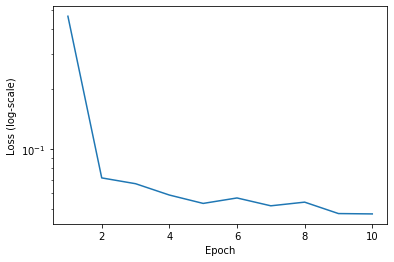

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [197]:
model = AE(input_shape=n_mut_types).to(device)
model.share_memory()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
objective = torch.nn.MSELoss()
epochs = 10

log = []
epoch = 0

# train, higher the epochs, lower the loss
while epoch < epochs:
    loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, n_mut_types).to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        train_loss = objective(outputs, batch)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)

    epoch += 1
    log.append((epoch, loss))
    # display the epoch training loss and accuracy
    if (epoch % print_stats_interval) == 0 or epoch == epochs:
        print('epoch={:.0f}, loss={:.5f}, val_loss={:.5f}, acc={:.5f}, val_acc={:.5f}'.format(epoch, loss, val_loss, acc, val_acc))

logdf = pd.DataFrame(log, columns=['epoch', 'loss'])
plt.plot(logdf['epoch'], logdf['loss'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log-scale)')
plt.show()

# extract latent codes learnt by the autoencoder for each tumor by encoding the log-transformed mutation counts.
model = model.to(device).eval()
res = model.encode(torch.cuda.FloatTensor(np.array(np.log10(mutations + 1))))
ae_res = pd.DataFrame(res.cpu().detach().numpy(), columns=['ae1', 'ae2'])
ae_res['tumor_type'] = tumor_types

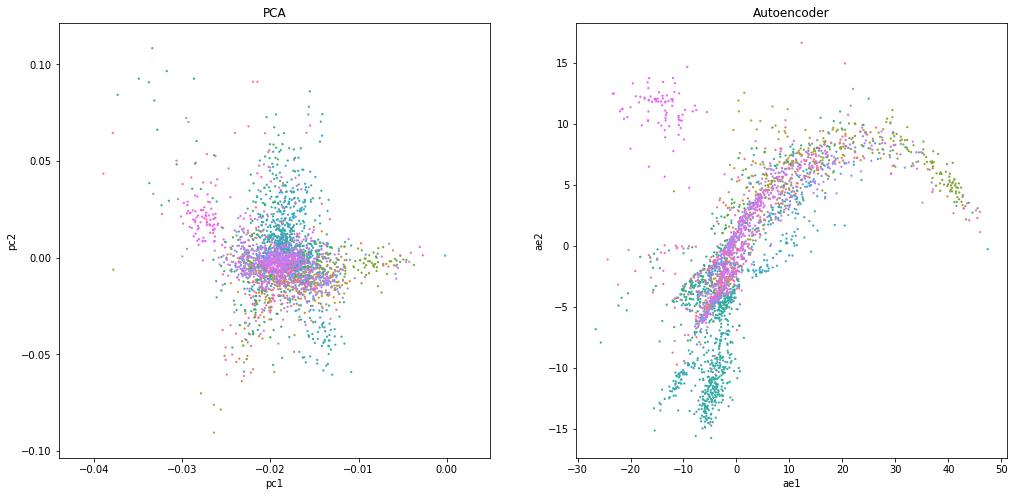

In [188]:

# Lets plot both the PCA and autoencoder side by side

plt.figure(figsize=(8 * 2 + 1, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x='pc1', y='pc2', hue='tumor_type', data=pca_res, linewidth=0, s=5, legend=False);
plt.title('PCA')
plt.subplot(1, 2, 2)
sns.scatterplot(x='ae1', y='ae2', hue='tumor_type', data=ae_res, linewidth=0, s=5, legend=False);
plt.title('Autoencoder');
plt.show()

In [ ]:
# We can see that autoencoder produces similar pattern